In [ ]:
# импортируем библтотеки необходимые нам для анализа
%matplotlib inline
import pandas as pd
import pg8000
import seaborn as sns
from matplotlib import pyplot as plt


: 

In [76]:
def get_registered_users_count():
    conn = pg8000.connect(
        user='skillfactory',
        password='cCkxxLVrDE8EbvjueeMedPKt',
        database='skillfactory',
        host='84.201.134.129',
        port=5432
    )

    query = '''
    SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-07-01'
    GROUP BY 1
    '''

    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()

    # Закрытие соединения
    cursor.close()
    conn.close()

    # Преобразуем результат в pandas DataFrame
    return pd.DataFrame(rows, columns=['registration_date', 'registered_users_count'])

# Получаем и выводим данные
registered_users_count = pd.DataFrame(get_registered_users_count())

1. Определим общее количество пользователей зарегистрировашихся по месяцам

In [77]:
# Изучаем полученный DF 'registered_users_coun'
registered_users_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       61 non-null     object
 1   registered_users_count  61 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [78]:
# признак 'registration_date' приведем к типу datetime64
registered_users_count['registration_date'] = pd.to_datetime(registered_users_count['registration_date'], format='%Y-%m-%dT%H:%M:%S')
registered_users_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   registration_date       61 non-null     datetime64[ns]
 1   registered_users_count  61 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [79]:
# условие отбора пользователей по месяцам (май и июнь)
may_condition = (
    '2019-05-01'<= registered_users_count.registration_date) &(
        registered_users_count.registration_date < '2019-06-01')
june_condition = (
    '2019-06-01'<= registered_users_count.registration_date) &(
        registered_users_count.registration_date < '2019-07-01')
display(registered_users_count[may_condition].head(3))
display(registered_users_count[june_condition].head(3))

,registration_date,registered_users_count
0,2019-05-01,6516
1,2019-05-02,5309
2,2019-05-03,6266


,registration_date,registered_users_count
31,2019-06-01,4833
32,2019-06-02,5255
33,2019-06-03,4193


In [80]:
registered_users_count_may = registered_users_count[may_condition]['registered_users_count'].sum()
registered_users_count_june = registered_users_count[june_condition]['registered_users_count'].sum()
print(
    """Количество пользователей зарегистрировавшихся в мае: {}
Количество пользователей зарегистрировавшихся в июне: {}""".format(
        registered_users_count_may, registered_users_count_june
    )
)

Количество пользователей зарегистрировавшихся в мае: 188943
Количество пользователей зарегистрировавшихся в июне: 100423


2. Определим количество пользователей вернувшихся в сервис по месяцам.

Мы можем посчитать количество активных пользователей в разрезе когорт, причём в качестве когорты будет выступать дата регистрации. Таким образом, мы определим количество активных пользователей по дням в разрезе даты регистрации.

In [81]:
#обратимся к таблице 1 и 2 из базы данных 
def getActiveUsersCountWithCohorts():
    query = '''
    SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-07-01'
    GROUP BY 1, 2
    '''
    
    # Подключаемся к базе данных с использованием pg8000
    conn = pg8000.connect(
        user='skillfactory',
        password='cCkxxLVrDE8EbvjueeMedPKt',
        database='skillfactory',
        host='84.201.134.129',
        port=5432
    )
    
    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()

    # Закрываем курсор и соединение
    cursor.close()
    conn.close()

    # Преобразуем результат в pandas DataFrame
    data = pd.DataFrame(rows, columns=['activity_date', 'registration_date', 'active_users_count'])

    return data

active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())

In [82]:
# изучим полученный DF
active_users_count_with_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891 entries, 0 to 1890
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       1891 non-null   object
 1   registration_date   1891 non-null   object
 2   active_users_count  1891 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 44.4+ KB


In [83]:
# переведем данные в признаках activity_date и registration_date к типу datetime
for col in ['activity_date', 'registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col], format='%Y-%m-%d')
active_users_count_with_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891 entries, 0 to 1890
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   activity_date       1891 non-null   datetime64[ns]
 1   registration_date   1891 non-null   datetime64[ns]
 2   active_users_count  1891 non-null   int64         
dtypes: datetime64[ns](2), int64(1)
memory usage: 44.4 KB


In [84]:
display(active_users_count_with_cohorts.head())
display(active_users_count_with_cohorts.tail())

,activity_date,registration_date,active_users_count
0,2019-05-01,2019-05-01,2590
1,2019-05-02,2019-05-01,2146
2,2019-05-02,2019-05-02,2049
3,2019-05-03,2019-05-01,1637
4,2019-05-03,2019-05-02,1817


,activity_date,registration_date,active_users_count
1886,2019-07-28,2019-06-29,129
1887,2019-07-28,2019-06-30,198
1888,2019-07-29,2019-06-29,89
1889,2019-07-29,2019-06-30,144
1890,2019-07-30,2019-06-30,91


In [85]:
# объединим DF active_users_count_with_cohorts и registered_users_count по признаку registration_date
retention_table = active_users_count_with_cohorts.merge(
    registered_users_count,
    how='left',
    on='registration_date'
)
# для каждой кагорты мы показали количество пользователей зарегистрированных в этот день
display(retention_table)

,activity_date,registration_date,active_users_count,registered_users_count
0,2019-05-01,2019-05-01,2590,6516
1,2019-05-02,2019-05-01,2146,6516
2,2019-05-02,2019-05-02,2049,5309
3,2019-05-03,2019-05-01,1637,6516
4,2019-05-03,2019-05-02,1817,5309
...,...,...,...,...
1886,2019-07-28,2019-06-29,129,2968
1887,2019-07-28,2019-06-30,198,3301
1888,2019-07-29,2019-06-29,89,2968
1889,2019-07-29,2019-06-30,144,3301


In [86]:
# Добавим в DF 'retention_table' признак 'retention_rate'
retention_table['retention_rate'] = retention_table.active_users_count / retention_table.registered_users_count
display(retention_table)

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-05-01,2019-05-01,2590,6516,0.397483
1,2019-05-02,2019-05-01,2146,6516,0.329343
2,2019-05-02,2019-05-02,2049,5309,0.385948
3,2019-05-03,2019-05-01,1637,6516,0.251228
4,2019-05-03,2019-05-02,1817,5309,0.342249
...,...,...,...,...,...
1886,2019-07-28,2019-06-29,129,2968,0.043464
1887,2019-07-28,2019-06-30,198,3301,0.059982
1888,2019-07-29,2019-06-29,89,2968,0.029987
1889,2019-07-29,2019-06-30,144,3301,0.043623


In [87]:
# добавим в DF 'retention_table' признак времени в днях между 'registration_date' и  'activity_date'
retention_table['timedelta'] = retention_table.activity_date - retention_table.registration_date
# получим целое количество дней путем деления на pd.Timedelta('1day')
retention_table.timedelta = retention_table.timedelta / pd.Timedelta('1day')
# приведем тип к целому числу
retention_table.timedelta = retention_table.timedelta.astype(int)
retention_table

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,timedelta
0,2019-05-01,2019-05-01,2590,6516,0.397483,0
1,2019-05-02,2019-05-01,2146,6516,0.329343,1
2,2019-05-02,2019-05-02,2049,5309,0.385948,0
3,2019-05-03,2019-05-01,1637,6516,0.251228,2
4,2019-05-03,2019-05-02,1817,5309,0.342249,1
...,...,...,...,...,...,...
1886,2019-07-28,2019-06-29,129,2968,0.043464,29
1887,2019-07-28,2019-06-30,198,3301,0.059982,28
1888,2019-07-29,2019-06-29,89,2968,0.029987,30
1889,2019-07-29,2019-06-30,144,3301,0.043623,29


In [88]:
# формируем уловия отбора по месяцам 
may_condition_1 = (
    '2019-05-01'<= retention_table.registration_date) & (
        retention_table.registration_date < '2019-06-01')
june_condition_1 = (
    '2019-06-01'<= retention_table.registration_date) & (
        retention_table.registration_date < '2019-07-01')

In [89]:
# построим сводную таблицу возвращаемости по кагортам сформированным по дням регистрации пользователя в мае
pivot_table_may = retention_table[may_condition_1].pivot_table(
    index='registration_date',
    columns='timedelta',
    values='retention_rate' 
)
pivot_table_may.head()

timedelta,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,0.397483,0.329343,0.251228,0.222683,0.198895,0.174954,0.153929,0.146255,0.133671,0.123082,...,0.072284,0.069828,0.068754,0.067219,0.067373,0.063536,0.062922,0.060773,0.043738,0.029619
2019-05-02,0.385948,0.342249,0.254285,0.219062,0.193633,0.164061,0.152006,0.140328,0.125071,0.117160,...,0.067056,0.059522,0.059898,0.061217,0.060652,0.058768,0.055943,0.053682,0.045018,0.031456
2019-05-03,0.381264,0.339291,0.256783,0.219438,0.188477,0.170124,0.148899,0.142834,0.132301,0.126716,...,0.071976,0.070859,0.072455,0.069103,0.067028,0.066550,0.063837,0.060166,0.046920,0.030961
2019-05-04,0.384651,0.335224,0.241232,0.191573,0.169348,0.150249,0.140178,0.137284,0.131728,0.116796,...,0.072925,0.071420,0.066906,0.065401,0.064012,0.061465,0.058456,0.057646,0.043176,0.029286
2019-05-05,0.383161,0.311944,0.227751,0.192398,0.170737,0.152549,0.145397,0.138755,0.121488,0.113518,...,0.067641,0.063962,0.061101,0.060693,0.058547,0.057014,0.053438,0.054256,0.043936,0.027179


In [90]:
# построим сводную таблицу возвращаемости по кагортам сформированным по дням регистрации пользователя в июне
pivot_table_june = retention_table[june_condition_1].pivot_table(
    index='registration_date',
    columns='timedelta',
    values='retention_rate',
    aggfunc='sum'
)
pivot_table_june.head()

timedelta,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,0.341610,0.295676,0.211256,0.175667,0.143596,0.134906,0.121664,0.112766,0.110904,0.099938,...,0.060418,0.061246,0.058763,0.055245,0.056487,0.050693,0.049659,0.050693,0.042003,0.028968
2019-06-02,0.367840,0.294957,0.221313,0.188202,0.164225,0.145576,0.130923,0.129971,0.121598,0.109610,...,0.073073,0.071931,0.068506,0.062797,0.061656,0.062797,0.063178,0.060514,0.044719,0.028925
2019-06-03,0.341522,0.296685,0.207727,0.173384,0.150727,0.123062,0.118054,0.115430,0.111376,0.099213,...,0.065109,0.064870,0.063916,0.057238,0.056284,0.051753,0.052707,0.051991,0.041975,0.028858
2019-06-04,0.351216,0.296853,0.229852,0.180019,0.147592,0.133047,0.135670,0.121841,0.106581,0.098236,...,0.063662,0.060324,0.058417,0.053648,0.051502,0.051979,0.051264,0.047926,0.036242,0.023605
2019-06-05,0.337419,0.305403,0.223112,0.172336,0.147324,0.140570,0.131816,0.118059,0.108304,0.097799,...,0.066033,0.064282,0.060030,0.056278,0.054527,0.054527,0.053527,0.051026,0.037519,0.027514


Text(217.25, 0.5, 'Кагорта')

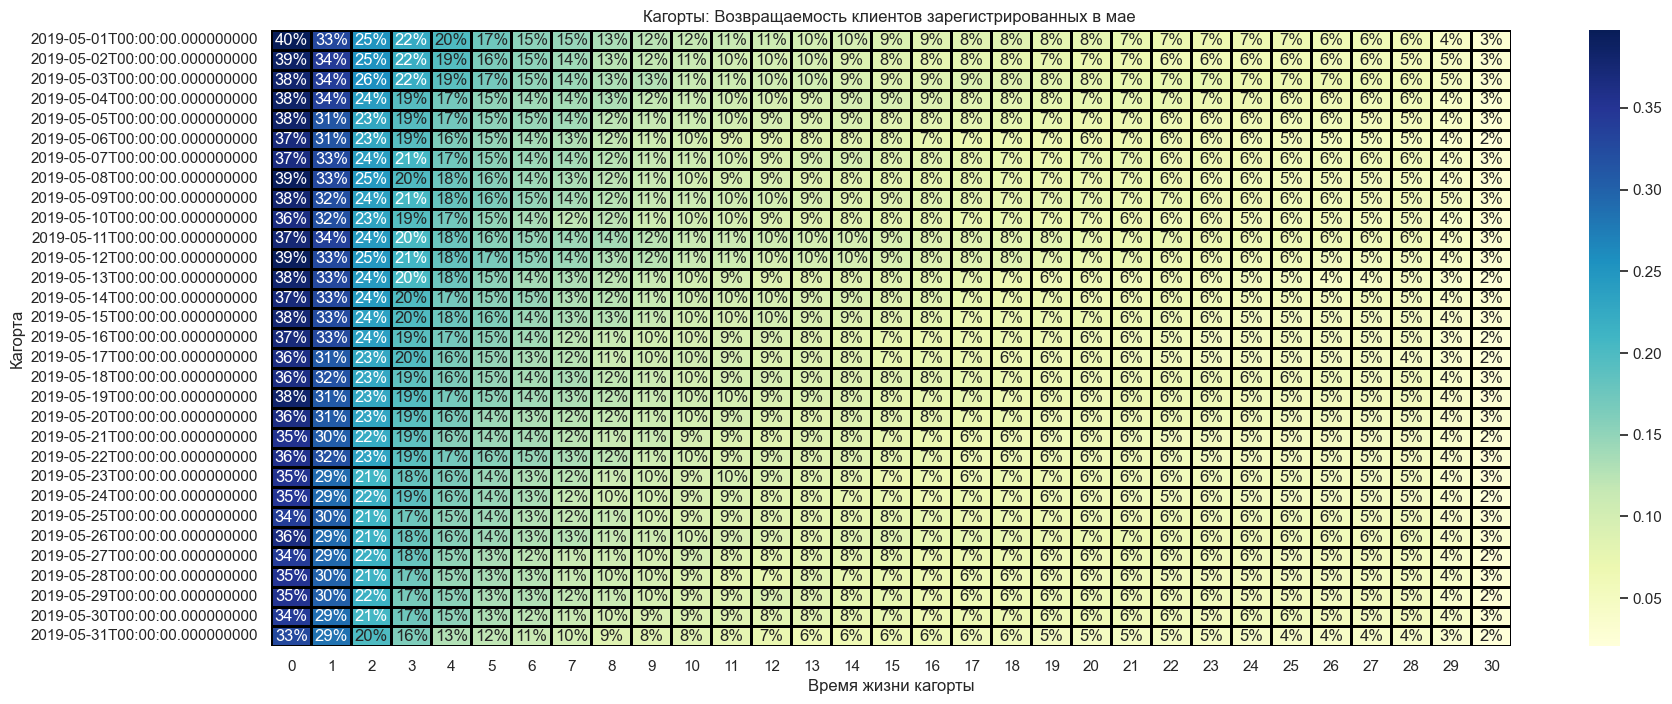

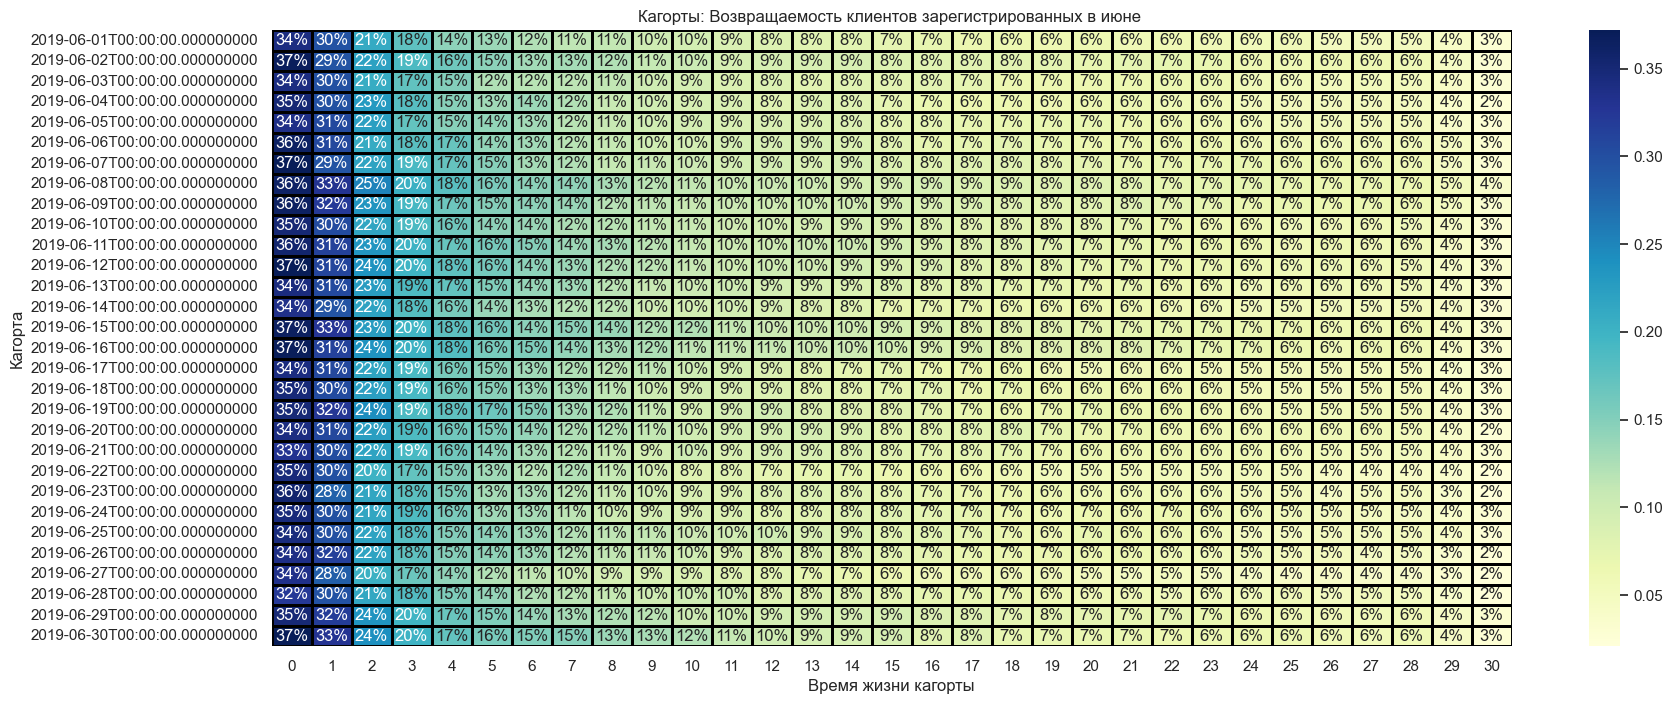

In [91]:
# построим тепловые карты возвращаемости клиентов по кагортам в мае и июне
sns.set(style='white')
plt.figure(figsize=(20, 8))
sns.heatmap(data=pivot_table_may, mask=pivot_table_may.isnull(), annot=True, fmt='.0%',linewidths=0.9, linecolor='black', cmap='YlGnBu')
plt.title('Кагорты: Возвращаемость клиентов зарегистрированных в мае ')
plt.xlabel('Время жизни кагорты')
plt.ylabel('Кагорта')

sns.set(style='white')
plt.figure(figsize=(20, 8))
sns.heatmap(data=pivot_table_june, mask=pivot_table_june.isnull(), annot=True, fmt='.0%',linewidths=0.9, linecolor='black', cmap='YlGnBu')
plt.title('Кагорты: Возвращаемость клиентов зарегистрированных в июне ')
plt.xlabel('Время жизни кагорты')
plt.ylabel('Кагорта')

3. Оценим изменение Retention Rate 1, 7 и 30 дней для первой и последней кагорты Мая и Июня.

Text(0.5, 0, 'Кагорта')

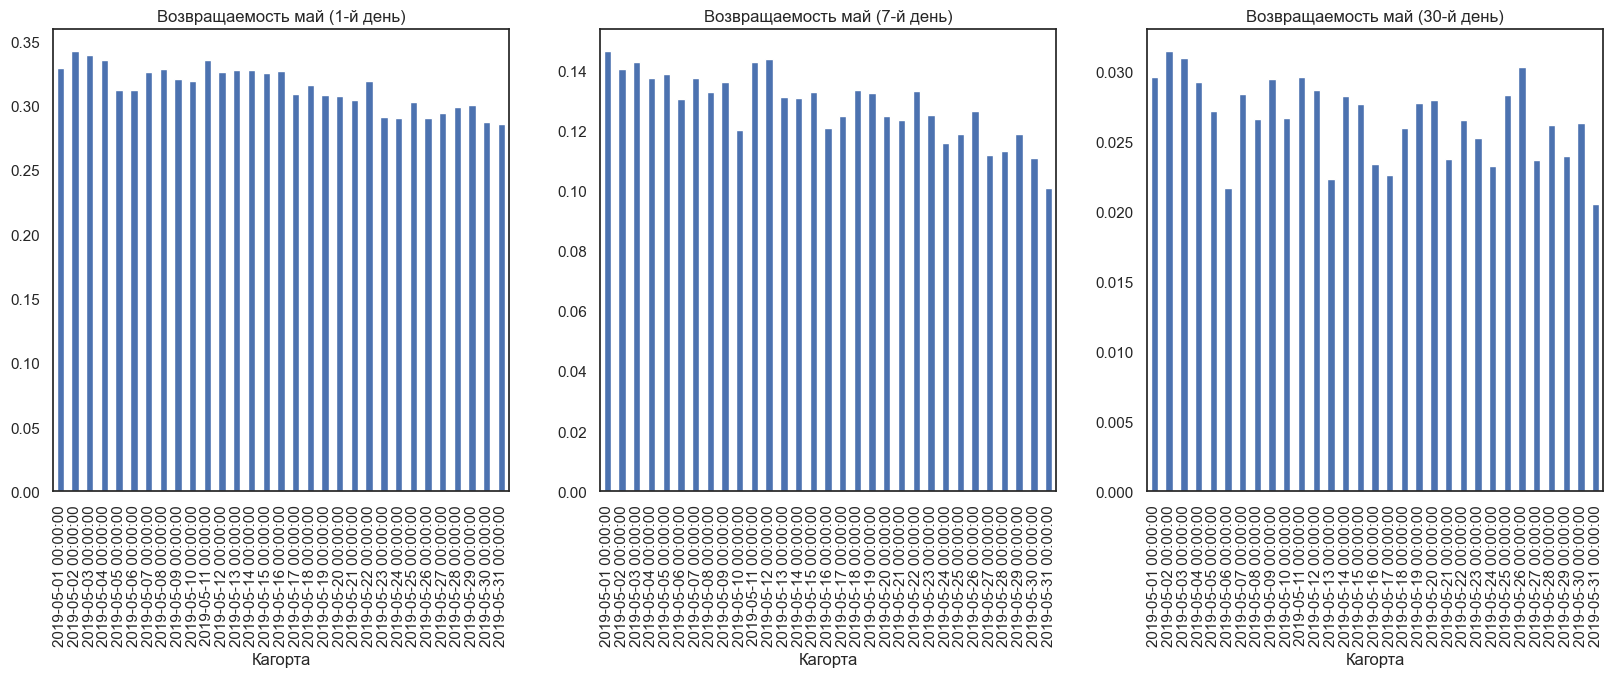

In [92]:
#Для наглядности построим графики Retentin Rate кагорт мая для 1, 7 и 30 дней
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
pivot_table_may[1].plot.bar(ax=axes[0])
axes[0].set_title('Возвращаемость май (1-й день)', fontsize=12);
axes[0].set_xlabel('Кагорта')

pivot_table_may[7].plot.bar(ax=axes[1])
axes[1].set_title('Возвращаемость май (7-й день)', fontsize=12);
axes[1].set_xlabel('Кагорта')

pivot_table_may[30].plot.bar(ax=axes[2])
axes[2].set_title('Возвращаемость май (30-й день)', fontsize=12);
axes[2].set_xlabel('Кагорта')


In [93]:
# расчитаем средний Retention rate для 1, 7 и 30 дня мая
print(pivot_table_may[1].mean())
print(pivot_table_may[7].mean())
print(pivot_table_may[30].mean())

0.31425602159749366
0.1282810329132895
0.026578866727205004


In [94]:
# посчитаем изменение возвращаемости пользователей зарегистрировавашихся в начале месяца относительно последней даты месяца

relative_change_may_0 = pivot_table_may[0]['2019-05-31'] / pivot_table_may[0]['2019-05-01']
relative_change_may_7 = pivot_table_may[7]['2019-05-31'] / pivot_table_may[7]['2019-05-01']
relative_change_may_30 = pivot_table_may[30]['2019-05-31'] / pivot_table_may[30]['2019-05-01']

print(
    """Retention Rate когорты 31 мая 2019 года на первый, седьмой и тридцатые дни составляют соответсвенно {:.2%}, {:.2%} и {:.2%} относительно 
аналогичных показателей когорты 1 мая 2019 года. 
Значит, мы можем говорить о том, что Retention Rate с течением времени, снижается. Что мы и наблюдаем на графике""".format(
    relative_change_may_0, relative_change_may_7, relative_change_may_30
)
)

Retention Rate когорты 31 мая 2019 года на первый, седьмой и тридцатые дни составляют соответсвенно 82.28%, 68.89% и 69.32% относительно 
аналогичных показателей когорты 1 мая 2019 года. 
Значит, мы можем говорить о том, что Retention Rate с течением времени, снижается. Что мы и наблюдаем на графике


Text(0.5, 0, 'Кагорта')

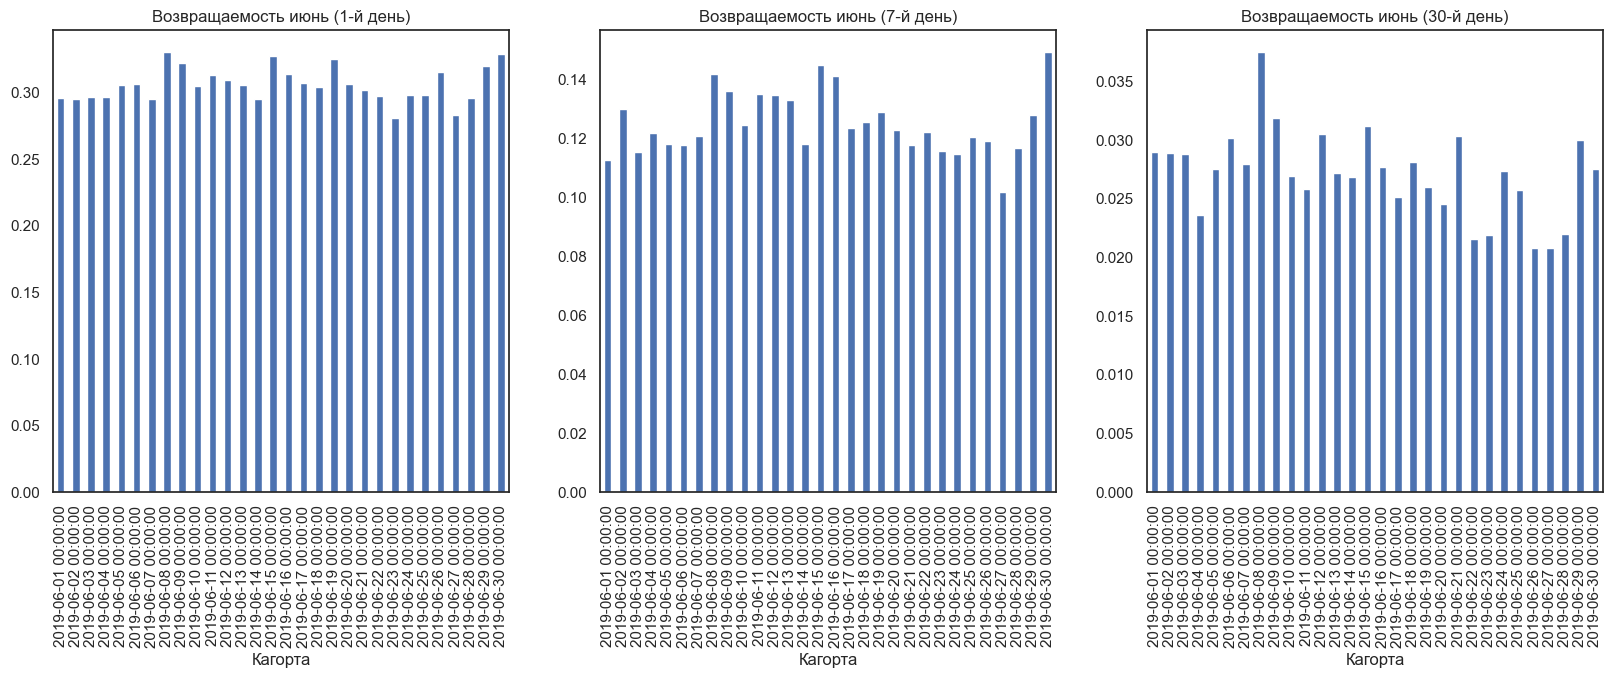

In [95]:
#Для наглядности построим графики Retentin Rate кагорт июня для 1, 7 и 30 дней
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
pivot_table_june[1].plot.bar(ax=axes[0])
axes[0].set_title('Возвращаемость июнь (1-й день)', fontsize=12);
axes[0].set_xlabel('Кагорта')

pivot_table_june[7].plot.bar(ax=axes[1])
axes[1].set_title('Возвращаемость июнь (7-й день)', fontsize=12);
axes[1].set_xlabel('Кагорта')

pivot_table_june[30].plot.bar(ax=axes[2])
axes[2].set_title('Возвращаемость июнь (30-й день)', fontsize=12);
axes[2].set_xlabel('Кагорта')

In [96]:
# расчитаем средний Retention rate для 1, 7 и 30 дня мая
print(pivot_table_june[1].mean())
print(pivot_table_june[7].mean())
print(pivot_table_june[30].mean())

0.30570718260835855
0.1251508394492788
0.02713012312596579


In [97]:
relative_change_june_0 = pivot_table_june[0]['2019-06-30'] / pivot_table_june[0]['2019-06-01']
relative_change_june_7 = pivot_table_june[7]['2019-06-30'] / pivot_table_june[7]['2019-06-01']
relative_change_june_30 = pivot_table_june[30]['2019-06-30'] / pivot_table_june[30]['2019-06-01']

print(
    """Retention Rate когорты 30 июня 2019 года на первый, седьмой и тридцатые дни составляют соответсвенно {:.2%}, {:.2%} и {:.2%} относительно 
аналогичных показателей когорты 1 июня 2019 года. 
Мы можем говорить о том, что Retention Rate с течением времени, растет. 
При  этом Retentin Rate на 30 день практически не изменяется. Что мы и наблюдаем на графике""".format(
    relative_change_june_0, relative_change_june_7, relative_change_june_30
)
)

Retention Rate когорты 30 июня 2019 года на первый, седьмой и тридцатые дни составляют соответсвенно 108.63%, 132.44% и 95.17% относительно 
аналогичных показателей когорты 1 июня 2019 года. 
Мы можем говорить о том, что Retention Rate с течением времени, растет. 
При  этом Retentin Rate на 30 день практически не изменяется. Что мы и наблюдаем на графике


4. Определяем выручку по месяцам

In [98]:
def getRevenue():
    query = '''
    SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-07-01'
    GROUP BY 1, 2
    '''
    
    # Подключаемся к базе данных с использованием pg8000
    conn = pg8000.connect(
        user='skillfactory',
        password='cCkxxLVrDE8EbvjueeMedPKt',
        database='skillfactory',
        host='84.201.134.129',
        port=5432
    )
    
    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()

    # Закрываем курсор и соединение
    cursor.close()
    conn.close()

    # Преобразуем результат в pandas DataFrame
    data = pd.DataFrame(rows, columns=['date', 'registration_date', 'users_count_with_revenue', 'revenue'])

    return data
revenue = getRevenue()

In [99]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1745 entries, 0 to 1744
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      1745 non-null   object 
 1   registration_date         1745 non-null   object 
 2   users_count_with_revenue  1745 non-null   int64  
 3   revenue                   1745 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 54.7+ KB


In [100]:
# приведем признаки ['date', 'registration_date'] к типу datetime
for col in ['date', 'registration_date']:
    revenue[col] = pd.to_datetime(revenue[col])

revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1745 entries, 0 to 1744
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      1745 non-null   datetime64[ns]
 1   registration_date         1745 non-null   datetime64[ns]
 2   users_count_with_revenue  1745 non-null   int64         
 3   revenue                   1745 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 54.7 KB


In [101]:
# условие отбора по месяцам для определения общей выручки за месяц
may_condition_2 = (
    (revenue.registration_date >= '2019-05-01') & (revenue.registration_date < '2019-06-01')
)
june_condition_2 = (
    (revenue.registration_date >= '2019-06-01') & (revenue.registration_date < '2019-07-01')
)
revenue_may = revenue[may_condition_2]['revenue'].sum()
revenue_june = revenue[june_condition_2]['revenue'].sum()
print(
    """Выручка в мае составила: {} 
Выручка в июне составила: {} """.format(round(revenue_may, 2), round(revenue_june, 2))
)

Выручка в мае составила: 121998.3 
Выручка в июне составила: 79685.87 


In [102]:
# Считаем среднюю выручку на пользователя 
revenue_may_per_user = revenue_may / registered_users_count_may
revenue_june_per_user  = revenue_june / registered_users_count_june

print('Среняя выручка на пользователя в мае: {:.2}'.format (revenue_may_per_user))
print('Средняя выручка на пользователя в июне: {:.2}'.format(revenue_june_per_user))
print('Превышение выручки июня относительно мая составляет: {:.2%}'.format(
    (revenue_june_per_user- revenue_may_per_user) / revenue_may_per_user))



Среняя выручка на пользователя в мае: 0.65
Средняя выручка на пользователя в июне: 0.79
Превышение выручки июня относительно мая составляет: 22.89%


5. ARPU И ARPPU

In [103]:
# Объединение DF 'retention_table'  и 'revenue'
# в DF 'revenue' столбец date в activity_date
revenue = revenue.rename(columns={'date': 'activity_date'})
# объединяем DF по признаку 'registration_date' и 'registration_date'
merge_DF = retention_table.merge(
    revenue,
    how='left',
    on=['registration_date', 'activity_date']
)
merge_DF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891 entries, 0 to 1890
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   activity_date             1891 non-null   datetime64[ns]
 1   registration_date         1891 non-null   datetime64[ns]
 2   active_users_count        1891 non-null   int64         
 3   registered_users_count    1891 non-null   int64         
 4   retention_rate            1891 non-null   float64       
 5   timedelta                 1891 non-null   int64         
 6   users_count_with_revenue  1745 non-null   float64       
 7   revenue                   1745 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(3)
memory usage: 118.3 KB


In [104]:
# Заменим значения NaN в признаках ['users_count_with_revenue', 'revenue'] на 0
for col in ['users_count_with_revenue', 'revenue']:
    merge_DF[col] = merge_DF[col].fillna(0)   
# Преобразуем тип в колонке users_count_with_revenue в целочисленный
merge_DF['users_count_with_revenue'] = merge_DF['users_count_with_revenue'].astype(int)
merge_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891 entries, 0 to 1890
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   activity_date             1891 non-null   datetime64[ns]
 1   registration_date         1891 non-null   datetime64[ns]
 2   active_users_count        1891 non-null   int64         
 3   registered_users_count    1891 non-null   int64         
 4   retention_rate            1891 non-null   float64       
 5   timedelta                 1891 non-null   int64         
 6   users_count_with_revenue  1891 non-null   int64         
 7   revenue                   1891 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(4)
memory usage: 118.3 KB


In [105]:
merge_DF.head(3)

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,timedelta,users_count_with_revenue,revenue
0,2019-05-01,2019-05-01,2590,6516,0.397483,0,1672,2357.590
1,2019-05-02,2019-05-01,2146,6516,0.329343,1,1420,514.679
2,2019-05-02,2019-05-02,2049,5309,0.385948,0,1367,1629.140


In [106]:
# Добавим признак ['ARPU'] в DF merge_DF
merge_DF['ARPU'] = merge_DF['revenue'] / merge_DF['active_users_count']
merge_DF.head(3)

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,timedelta,users_count_with_revenue,revenue,ARPU
0,2019-05-01,2019-05-01,2590,6516,0.397483,0,1672,2357.590,0.910266
1,2019-05-02,2019-05-01,2146,6516,0.329343,1,1420,514.679,0.239832
2,2019-05-02,2019-05-02,2049,5309,0.385948,0,1367,1629.140,0.795090


In [107]:
# Добавим признак ['ARPPU'] в DF merge_DF
merge_DF['ARPPU'] = merge_DF['revenue'] / merge_DF['users_count_with_revenue']
merge_DF.head(3)

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,timedelta,users_count_with_revenue,revenue,ARPU,ARPPU
0,2019-05-01,2019-05-01,2590,6516,0.397483,0,1672,2357.590,0.910266,1.410042
1,2019-05-02,2019-05-01,2146,6516,0.329343,1,1420,514.679,0.239832,0.362450
2,2019-05-02,2019-05-02,2049,5309,0.385948,0,1367,1629.140,0.795090,1.191763


In [108]:
# Фильтруем данные за май 2019 года
may_data = merge_DF[(merge_DF.registration_date >= '2019-05-01') & (merge_DF.registration_date < '2019-06-01')]

# Вычисляем ARPPU, добавляя защиту от деления на ноль
revenue_sum = may_data['revenue'].sum()
users_count_sum = may_data['users_count_with_revenue'].sum()

# Проверяем, чтобы избежать деления на ноль
arppu_may_avg = revenue_sum / users_count_sum if users_count_sum > 0 else 0

# Выводим результат
print(round(arppu_may_avg, 2))

0.31


In [109]:
# Фильтруем данные за июнь 2019 года
june_data = merge_DF[(merge_DF.registration_date >= '2019-06-01') & (merge_DF.registration_date < '2019-07-01')]

# Вычисляем ARPPU для июня, добавляя защиту от деления на ноль
revenue_sum_june = june_data['revenue'].sum()
users_count_sum_june = june_data['users_count_with_revenue'].sum()

# Проверяем, чтобы избежать деления на ноль
arppu_june_avg = revenue_sum_june / users_count_sum_june if users_count_sum_june > 0 else 0

# Выводим результат
print(round(arppu_june_avg, 2))

0.39


Вывод:

1. Средний показатель Retention Rate в мае незначительно выше чем в июне после введения фичи. При этом мы видим рост retention rate в кагортах с течением времени. Можно предположить? что на тенденцию роста положительно влияет введенная фича.

2. Средний ARPPU мае составляет 0.31 у.е. В июне мы видим увеличение среднего ARPPU до 0.39 у.е. При этом средняя выручка за июнь на зарегистрированного пользователя так же увеличилась с 0.65 у.е. до 0.79 у.е. Увеличение средней выручки составляет 22.89%.

В целом мы можем предположить, что введение новой фичи благоприятно сказалось на показатели retention rate, ARPU и ARPPU